In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
from nltk.corpus import brown
import string
import gensim.downloader as api
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)

ModuleNotFoundError: No module named 'gensim'

### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

In [2]:
class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        self.data = list(set(brown.words()))[0:5000]
        self.word_to_idx = {word: index for index, word in enumerate(self.data)} # Convert the unique words to an index dictionary {word: index}
        self.targets = list(self.word_to_idx.values()) # Make these indexes the target values

    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        letter_indices = [0] * 26
        alphabet = list(string.ascii_lowercase)

        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.
        letter_indices = torch.zeros(26)
        for letter in x:
            if letter.lower() in alphabet:
                idx = alphabet.index(letter.lower())
                letter_indices[idx] += 1
        
        x = torch.tensor(letter_indices, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        return x, y

### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()

        # Bookkeeping: Saving the initialization parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Implement the neural network layers, the activation function is already defined
        self.input_layer = nn.Linear(self.input_size, self.hidden_size[0])
        self.hidden_layer = nn.Linear(self.hidden_size[0], self.hidden_size[1])
        self.output_layer = nn.Linear(self.hidden_size[1], self.output_size)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # In the forward pass the model will calculate the gradients as well as the probabilities of the result occuring given its input.
        # Implement the missing layers

        x = self.input_layer(x) # Implement input layer
        x = self.activation(x)
        x = self.hidden_layer(x) # Implement hidden layer
        x = self.activation(x)
        x = self.output_layer(x) # Implement the output layer

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [5]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'cpu' # If you have an m1 macbook use: 'mbp', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [6]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [7]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [8]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

/var/folders/f5/qnyy8fcs5pb39rm6h2zwy0ch0000gn/T/ipykernel_98320/1552140970.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(letter_indices, dtype=torch.float32)


Training_loss: 8.509917259216309
Validation_loss: 1.0698073625564575
Training_loss: 8.479467391967773
Validation_loss: 1.0807847380638123
Training_loss: 8.341395378112793
Validation_loss: 1.098809494972229
Training_loss: 8.091596603393555
Validation_loss: 1.1289737296104432
Training_loss: 8.037162780761719
Validation_loss: 1.1731679487228392
Training_loss: 7.910111427307129
Validation_loss: 1.2277706503868102
Training_loss: 7.835783004760742
Validation_loss: 1.287344250679016
Training_loss: 7.596810340881348
Validation_loss: 1.3485180306434632
Training_loss: 7.482251167297363
Validation_loss: 1.4098142170906067
Training_loss: 7.269768238067627
Validation_loss: 1.4715874695777893
Training_loss: 7.459245204925537
Validation_loss: 1.5343756437301637
Training_loss: 7.364700794219971
Validation_loss: 1.5991591835021972
Training_loss: 7.165571212768555
Validation_loss: 1.6662110662460328
Training_loss: 7.014688491821289
Validation_loss: 1.7363651514053344
Training_loss: 7.00423002243042
Vali

### Writing
Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?

An increasing validation loss often indicates that the model is overfitting on the training data. This means that the model's weights adjusts specifically to predict the training data well, and thus doesn't generalize well on other, not seen, data. 

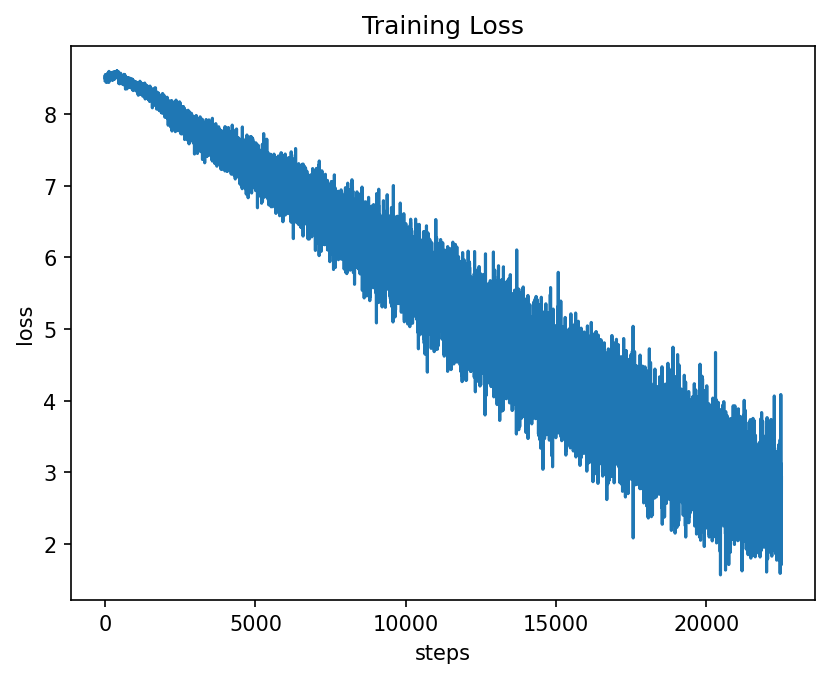

In [9]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

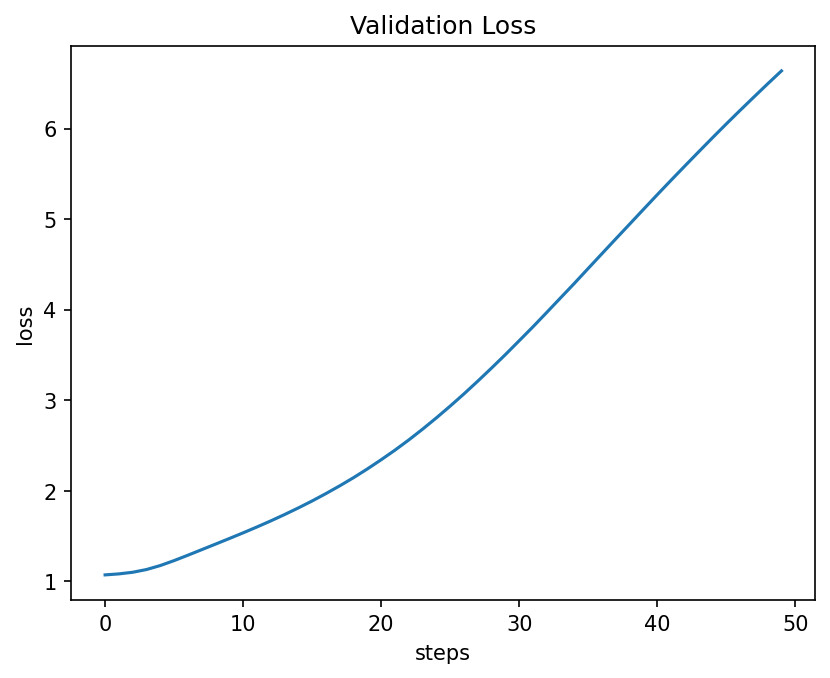

In [10]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
Belowe we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?

What stands out from the results is that the model's predictions are often not correct. For example, the target 'Payne' is predicted as 'unhappy'. Notable is that the predicted words often do have the same letters as the target words, however, the main difference is the order of the letters. They also occasionally added extra letters, such as an additional 'p', or introduced new letters like 'h' and 'u'. In contrast, they sometimes also removed letters, such as 'e', as seen in examples like 'Payne' and 'unhappy'. 

In [11]:
def get_n_words(dataset, n, model, ds, verbose = True):
    if n == -1:
        n = len(dataset)
    x = [dataset.__getitem__(i)[0] for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    target_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in y]
    out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
    predicted_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in out]
    width = max(len(word) for word in target_words) + 5
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    return target_words, predicted_words

_,_ = get_n_words(test_dataset, 10, model, dataset)

target: Payne             predicted: unhappy
target: co-ordinated      predicted: dedication
target: cahoots           predicted: shoot
target: Oregon            predicted: overcoming
target: Provision         predicted: provisions
target: freer             predicted: referred
target: serves            predicted: Observers
target: Gunny             predicted: young
target: current           predicted: Tucker
target: canine            predicted: machinegun


/var/folders/f5/qnyy8fcs5pb39rm6h2zwy0ch0000gn/T/ipykernel_98320/1552140970.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(letter_indices, dtype=torch.float32)
/var/folders/f5/qnyy8fcs5pb39rm6h2zwy0ch0000gn/T/ipykernel_98320/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


Why are some words incorrectly predicted?

The input to the model is a vector that represents the frequency of each individual letter in the target word. However, the model does not have explicit knowledge of how each position in the vector corresponds to a specific letter (e.g., that position 0 corresponds to the letter 'a'). Instead, the model learns to predict words directly from the input vector, without access to this translation.

It predicts a word and calculates the loss by comparing it to the target word. This loss is then used to update the model's weights through backpropagation. As a result, the predicted words do not always match the exact number of letters of the given input vector. Additionally, since the input vector contains only frequency information, it lacks any information about the order of the letters, which further contributes to incorrect predictions.

### Code + Written
Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.

[Your answer here]

In [ ]:
# Method 1: Jaccard
target_words,predicted_words = get_n_words(test_dataset, -1, model, dataset)
total_jaccard = 0

# Loop over all target and predicted words
for i in range(len(target_words)):
    target_word = set(target_words[i].lower())
    predicted_word = set(predicted_words[i].lower())

    # Compute the intersection and union
    intersection = target_word.intersection(predicted_word)
    union = target_word.union(predicted_word)

    # Compute Jaccard score with the lengths of intersection and union
    jaccard = float(len(intersection) / len(union))

    # Keep score of the total Jaccard, needed for avergae
    total_jaccard += jaccard

    # Add some print statements to visualize
    if i >= 0 and i < 5:
        print(f'Target word is {target_words[i]}, predicted word is {predicted_words[i]}, Jaccard similarity is {round(jaccard,2)}')

print(f'Average Jaccard similarity score is {round(total_jaccard/len(target_words),2)}')

/var/folders/f5/qnyy8fcs5pb39rm6h2zwy0ch0000gn/T/ipykernel_98320/1552140970.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(letter_indices, dtype=torch.float32)
/var/folders/f5/qnyy8fcs5pb39rm6h2zwy0ch0000gn/T/ipykernel_98320/2019737341.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


target: Payne                         predicted: unhappy
target: co-ordinated                  predicted: dedication
target: cahoots                       predicted: shoot
target: Oregon                        predicted: overcoming
target: Provision                     predicted: provisions
target: freer                         predicted: referred
target: serves                        predicted: Observers
target: Gunny                         predicted: young
target: current                       predicted: Tucker
target: canine                        predicted: machinegun
target: foot-high                     predicted: Lightfoot
target: lilacs                        predicted: Bacillus
target: Congress'                     predicted: Recordings
target: lathes                        predicted: pathless
target: workmen                       predicted: Sermon
target: exploration                   predicted: operation
target: freeman                       predicted: germane
target: upon 

In [37]:
# Method 2: Cosine Similarity
wv_from_bin = api.load("glove-wiki-gigaword-200")
target_words,predicted_words = get_n_words(test_dataset, -1, model, dataset)
total_distance = 0

print(wv_from_bin.distance('hot', 'warm'))    # synonym

# Loop over all target and predicted words
for i in range(len(target_words)):
    target_word = target_words[i].lower()
    predicted_word = predicted_words[i].lower()
    distance = wv_from_bin.distance(target_word, predicted_word)
    total_distance += distance

    # Add some print statements to visualize
    if i >= 0 and i < 5:
        print(f'Target word is {target_words[i]}, predicted word is {predicted_words[i]}, Cosine similarity is {round(distance,2)}')

print(f'Average Cosine similarity score is {round(total_distance/len(target_words),2)}')

NameError: name 'api' is not defined